# Скачивание датасета с Kaggle

Датасет: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

Построим модель, которая классифицирует наличие опухоли (или её тип) по снимкам МРТ


In [ ]:
! pip install -q kaggle --quiet

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darkground","key":"..."}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 85% 74.0M/86.8M [00:00<00:00, 119MB/s] 
100% 86.8M/86.8M [00:00<00:00, 120MB/s]


In [ ]:
! unzip  '/content/brain-tumor-classification-mri.zip' -d '/content/brain-tumor-classification-mri'

In [ ]:
! pip install torchinfo --quiet
! pip install pytorch-ignite --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 5.9 MB/s eta 0:00:00


# Загрузка датасета в Torch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [3]:
transform = T.Compose([T.Resize([224,224]), T.ToTensor()])

In [4]:
train_dir = "/content/brain-tumor-classification-mri/Training"
test_dir = "/content/brain-tumor-classification-mri/Testing"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

print(len(train_dataset), len(test_dataset))

2870 394


In [5]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [6]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([128, 3, 224, 224])


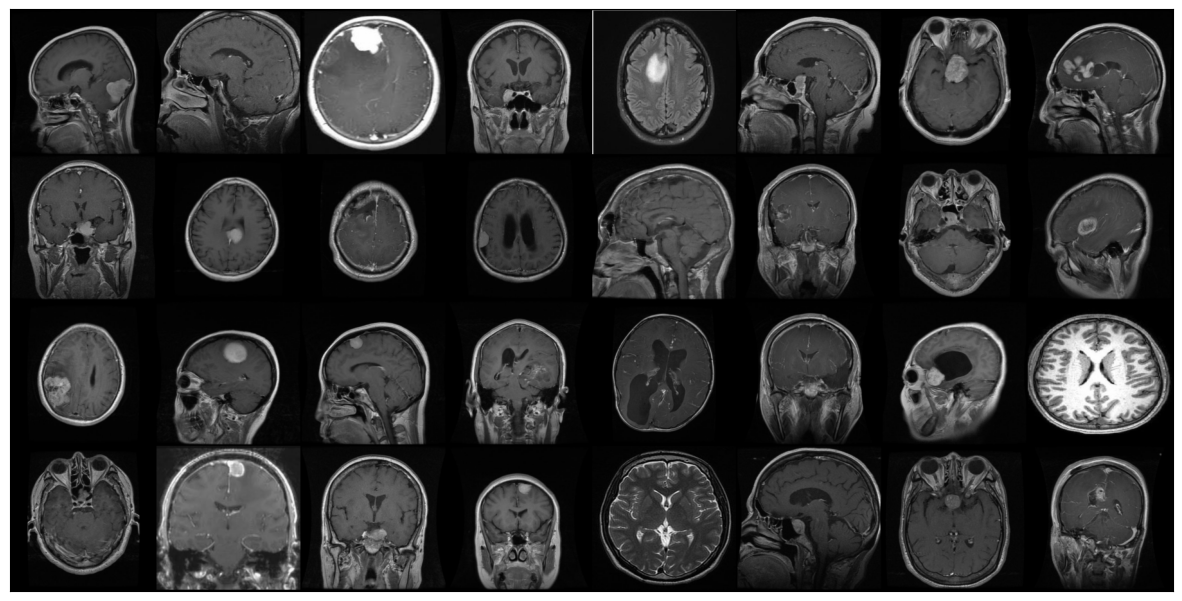

In [7]:
show_batch(train_loader)

Используем EfficientNet B0 с 4мя классами

In [8]:
import torchvision.models as models
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(1280, 4)
model.to(device);

In [9]:
from torchinfo import summary
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 4]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

Делаем акцент на наличие опухолей, а не их отсутствие

In [10]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(weight=torch.tensor([2.2,2.2,0.9,2.0]).to(device))

In [11]:
import shutil
import os
if os.path.isdir('./models'):
  shutil.rmtree('./models')

In [12]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [13]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [14]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=4)}

In [15]:
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
test_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [16]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [17]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [18]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [19]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer)
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [20]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

/usr/local/lib/python3.10/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [21]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = test_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

# Тренировка модели

Максимум 10 эпох

  4%|4         | 1/23 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 97.87 Сред. ошибка: 0.07032
Результат валидации - Эпоха: 6  Сред. точность: 78.43 Сред. ошибка: 1.57273


  4%|4         | 1/23 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 99.86 Сред. ошибка: 0.00373
Результат валидации - Эпоха: 7  Сред. точность: 79.95 Сред. ошибка: 1.68287


  4%|4         | 1/23 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 99.90 Сред. ошибка: 0.00224
Результат валидации - Эпоха: 8  Сред. точность: 79.70 Сред. ошибка: 2.12433


  4%|4         | 1/23 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.93 Сред. ошибка: 0.00337
Результат валидации - Эпоха: 9  Сред. точность: 79.95 Сред. ошибка: 1.93459


  4%|4         | 1/23 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.93 Сред. ошибка: 0.00408
Результат валидации - Эпоха: 10  Сред. точность: 79.44 Сред. ошибка: 1.93839


State:
	iteration: 230
	epoch: 10
	epoch_length: 23
	max_epochs: 10
	output: 0.0026376722380518913
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

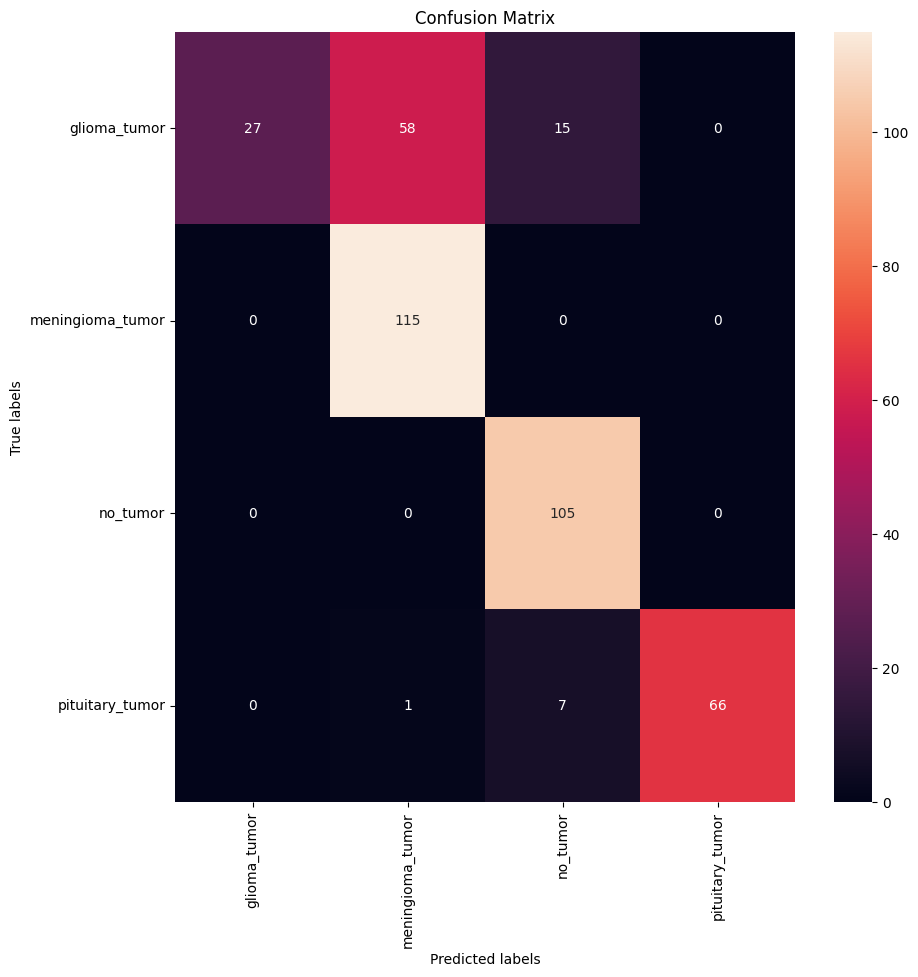

In [23]:
trainer.run(train_loader, max_epochs=10)

# Анализ результатов

Для архитектуры B0 результат вполне хороший: accuracy=0.79

Модель хорошо различает отсутствие от наличие опухоли, но при этом  
тяжело отличает опухоль Glioma от опухоли Meningioma.

Плохое различие может быть вызвано недостаточностью глубины архитектуры модели B0, а так же несбалансированность выбранного датасета.